In [1]:
import re
import seaborn as sns
import pandas_gbq
import pydata_google_auth
import pandas as pd
import numpy as np

import time
import os
from scipy.stats import mode
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from datetime import timedelta
import seaborn as sns


from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity



#不用print直接打印
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"         
pd.set_option('display.max_rows', 500)

#Bigquery設定
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]

credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    # Set auth_local_webserver to True to have a slightly more convienient
    # authorization flow. Note, this doesn't work if you're running from a
    # notebook on a remote sever, such as over SSH or with Google Colab.
    auth_local_webserver=True,)

#Plt畫圖設定
COLOR = "white"
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['font.size'] = 14 
plt.rcParams['lines.linewidth'] = 4

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['lines.linewidth'] = 2.5


#切分日期的function
def split_d(data,s,e):
    df = data[(data['day'] >= s) & (data['day'] <=e)]
    return df

#切分平台, x = 月份
def split_platform(df_rev,x1,x2):
    all_pur = pd.concat([ split_d(df_rev,date_list[0],date_list[1])['product_id'].value_counts().astype('int64').round(),split_d(df_rev,date_list[2],date_list[3])['product_id'].value_counts().astype('int64')], axis = 1)
    all_pur.columns = [x1,x2]
    return all_pur



def trend_line(data):
    (arg1, arg2),text1 = reg(np.arange(0,len(data.index)),data) 
    trend = np.arange(0,len(data.index)) *arg1 + arg2 #做出趨勢線矩陣

    return trend

def reg(x,y):
    coefficients = np.polyfit(x,y,1) # 利用 polyfit 幫我們算出資料 一階擬合的 a, b 參數
    p = np.poly1d(coefficients) # 做出公式, print 的結果是 coefficients[0] * X + coefficients[1]
    #coefficient_of_dermination = r2_score(y, p(x)) // 計算相關係數用，這裡沒有用到
    return coefficients, p

#取路徑
path = os.path.abspath(os.path.join(os.getcwd(), "..")+'/02_Data')

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

In [2]:
#取路徑
path = os.getcwd()
path
distinct_folder = os.path.dirname(os.getcwd())+'/02_Data/'
distinct_folder

'/Users/vin/Documents/Vin_Document/Analytics/Ptfarm/22_LFT+RFM+ML/01_App'

'/Users/vin/Documents/Vin_Document/Analytics/Ptfarm/22_LFT+RFM+ML/02_Data/'

In [3]:
#查看Dau個國家的組成
query = f'''
with c as (SELECT 
    user_id,
    event_name,
    product_id,
    extract(date FROM timestamp_micros(event_timestamp)) as event_date,
    event_value_in_usd rev,
    country,
    operating_system
FROM 
    `firebase-pokerrrr.pokerrrr.backup_20210818` 
where 
    date(timestamp_micros(event_timestamp)) between '2020-12-01' and '2021-12-01'
    and event_name = 'in_app_purchase')

SELECT 
    user_id,
    max(country) as ct,
    max(operating_system) os,
    max(event_date) customer_max_date,
    min(event_date) customer_min_date,
    extract(day from (max(event_date) - min(event_date))) recency,
    (select max(event_date) from c group by event_name) max_all,
    extract(day from (select max(event_date) from c group by event_name) - min(event_date)) T,
    count(event_name) - 1 as frequency,
    sum(rev) total_rev
FROM 
    c
group by 
    user_id
order by max_all asc
'''
df_rfm = pandas_gbq.read_gbq(query
    ,project_id="firebase-pokerrrr", 
    credentials=credentials)
df_rfm.to_csv(distinct_folder+f'df_rfm.csv',index = False)

Downloading: 100%|██████████| 83372/83372 [00:17<00:00, 4896.24rows/s]


In [51]:
query = f'''
with c as (SELECT 
    user_id,
    event_name,
    product_id,
    extract(date FROM timestamp_micros(event_timestamp)) as event_date,
    event_value_in_usd rev,
    country,
    operating_system
FROM 
    `firebase-pokerrrr.pokerrrr.backup_20210818` 
where 
    date(timestamp_micros(event_timestamp)) between '2020-12-01' and '2021-12-01'
    and event_name = 'in_app_purchase')

select * from c
'''
df_rfm_raw = pandas_gbq.read_gbq(query
    ,project_id="firebase-pokerrrr", 
    credentials=credentials)
df_rfm_raw.to_csv(distinct_folder+f'df_rfm.csv',index = False)

Downloading: 100%|██████████| 453412/453412 [00:55<00:00, 8144.64rows/s]


In [52]:
df_rfm_raw.loc[df_rfm_raw['event_name']=='in_app_purchase','product_id'] = df_rfm_raw[df_rfm_raw['event_name']=='in_app_purchase']['product_id'].apply(lambda x:re.findall("\w+",x)[3])


In [53]:
# df_rfm_raw = df_rfm_raw[df_rfm_raw['product_id'] != 'welcome']

In [54]:
df_rfm.loc[df_rfm[df_rfm['os']=='ANDROID'].index,'os'] = 'Android'
df_rfm.loc[df_rfm[df_rfm['os']=='IOS'].index,'os'] = 'iOS'

df_rfm_raw.loc[df_rfm_raw[df_rfm_raw['operating_system']=='ANDROID'].index,'operating_system'] = 'Android'
df_rfm_raw.loc[df_rfm_raw[df_rfm_raw['operating_system']=='IOS'].index,'operating_system'] = 'iOS'

# 付費玩家比

In [55]:
df_rfm['os'].value_counts()

iOS        60370
Android    23002
Name: os, dtype: int64

In [56]:
df_rfm['os'].value_counts().values/df_rfm.user_id.count()

array([0.72, 0.28])

In [57]:
df_rfm_raw['operating_system'].value_counts()

iOS        322840
Android    130572
Name: operating_system, dtype: int64

In [58]:
df_t = df_rfm_raw

# 1.1 模型驗證測試

In [59]:
# train/test split (calibration/holdout)
t_holdout = 90 # 驗證資料90天                             # days to reserve for holdout period

max_date = df_t["event_date"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = df_t, 
        customer_id_col = "user_id", 
        datetime_col = "event_date",
        monetary_value_col = "rev", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2021-12-01 00:00:00
end of calibration period: 2021-09-02 00:00:00
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
user_id,,,,,,,
584c4c27d8c483735c2feaf5,0,0,137,0,0,0,90
584c82c7d8c483735c301849,0,0,210,0,1,5,90
584d0927d8c483735c3053cb,0,0,22,0,0,0,90
584d24a1d8c483735c30669b,0,0,103,0,0,0,90
584d3eafd8c483735c307ab1,0,0,104,0,0,0,90
...,...,...,...,...,...,...,...
6130f0042e5341054d1c5203,0,0,0,0,0,0,90
613137ca53ac72054905fd3e,0,0,0,0,0,0,90
613151e724c59e81a0c4a518,0,0,0,0,2,9,90


In [60]:

# training: frequency
pd.options.display.float_format = '{:,.3f}'.format
x = df_ch["frequency_cal"].value_counts(normalize=True)
x = x.nlargest(15)
print("frequency:")
x.sort_index(ascending=True)

frequency:


0.000    0.498
1.000    0.162
2.000    0.084
3.000    0.052
4.000    0.036
5.000    0.026
6.000    0.019
7.000    0.016
8.000    0.013
9.000    0.011
10.000   0.009
11.000   0.008
12.000   0.006
13.000   0.005
14.000   0.005
Name: frequency_cal, dtype: float64

## 1.2 觀察資料分布
大部分客戶都是五次內購買   
觀察到大部分客戶都是一次購買   
說明穩定的吸引玩家消費

(0.0, 27.0)

Text(0.5, 1.0, 'frequency (days): distribution of the customers')

(0.0, 275.0)

Text(0.5, 1.0, 'recency (days): distribution of the customers')

(0.0, 275.0)

Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

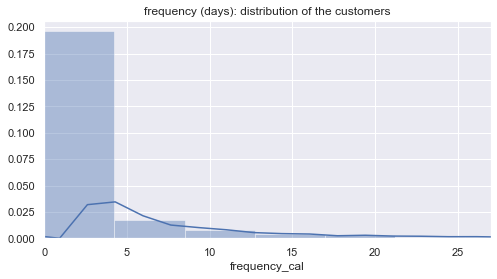

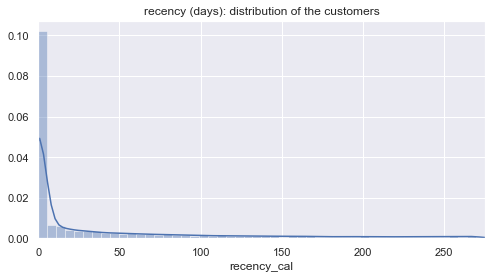

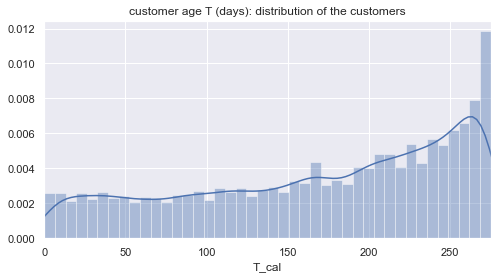

In [61]:
# training: axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()


# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");


# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")


# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

In [62]:

# training: BG/NBD model

# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: -5.659438
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21


<lifetimes.BetaGeoFitter: fitted with 70956 subjects, a: 0.74, alpha: 4.00, b: 2.61, r: 0.21>

# 1.3測試資料與模型預測

<Figure size 864x864 with 0 Axes>

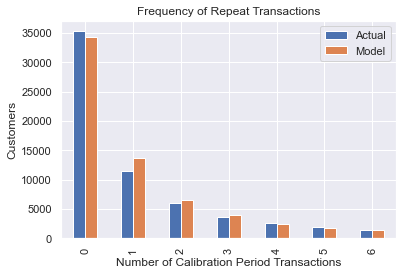

In [63]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

# 1.4 擬合
觀察到訓練資料量越大模型越擬合

<Figure size 504x504 with 0 Axes>

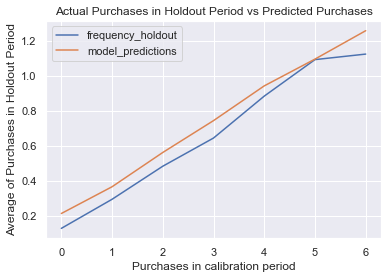

In [64]:

# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);


# 2.1 Full Training

In [110]:

# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
        transactions = df_t, 
        customer_id_col = "user_id", 
        datetime_col = "event_date",
        monetary_value_col = "rev",  
        observation_period_end = max_date, 
        freq = "D")  

pd.options.display.float_format = '{:.2f}'.format
df_rft

,frequency,recency,T,monetary_value
user_id,,,,
584c4c27d8c483735c2feaf5,0.00,0.00,227.00,0.00
584c82c7d8c483735c301849,1.00,212.00,300.00,4.99
584d0927d8c483735c3053cb,0.00,0.00,112.00,0.00
584d24a1d8c483735c30669b,0.00,0.00,193.00,0.00
584d3eafd8c483735c307ab1,0.00,0.00,194.00,0.00
...,...,...,...,...
61a7cc59d2e57a054781e9e2,0.00,0.00,0.00,0.00
61a7d124dca11a0554566d3b,0.00,0.00,0.00,0.00
61a7ece8d2e57a0547f51e94,0.00,0.00,0.00,0.00


# 2.2 模型 fit

In [66]:

# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -7.002304
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21


<lifetimes.BetaGeoFitter: fitted with 83371 subjects, a: 0.76, alpha: 3.68, b: 2.52, r: 0.19>

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.190,0.001,0.187,0.192
alpha,3.679,0.045,3.591,3.766
a,0.761,0.012,0.738,0.783
b,2.520,0.057,2.408,2.633


253


<Figure size 864x864 with 0 Axes>

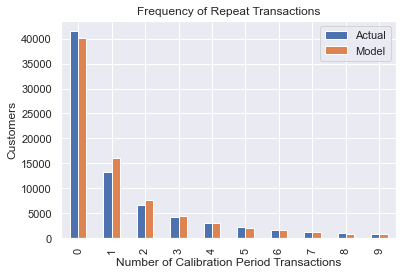

In [67]:

#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)


# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

# 2.3 熱區圖

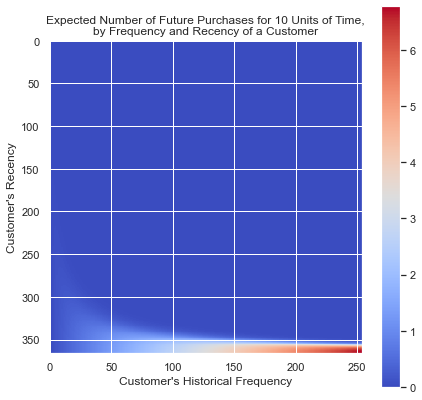

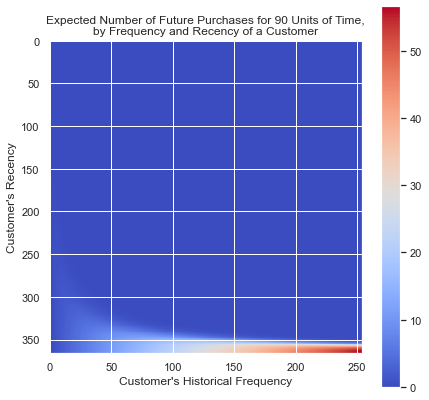

In [68]:
# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);
            
            
# call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

In [69]:
# predict purchases for a selected customer for t days
t = 30
custID = '5ea1005551e6747dd1721106'

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(    t, 
                        df_rft_C["frequency"], 
                        df_rft_C["recency"], 
                        df_rft_C["T"])
print("customer", custID, ": expected number of purchases within", t, "days =", f'{predC:.1f}')


customer 5ea1005551e6747dd1721106 : expected number of purchases within 30 days = 17.1


In [70]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])
                    
                    
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
user_id,,,,,,,,
584c4c27d8c483735c2feaf5,0.0,0.0,227.0,0.0,0.0,0.0,0.0,0.1
584c82c7d8c483735c301849,1.0,212.0,300.0,5.0,0.0,0.1,0.2,0.2
584d0927d8c483735c3053cb,0.0,0.0,112.0,0.0,0.0,0.0,0.1,0.1
584d24a1d8c483735c30669b,0.0,0.0,193.0,0.0,0.0,0.0,0.1,0.1
584d3eafd8c483735c307ab1,0.0,0.0,194.0,0.0,0.0,0.0,0.1,0.1
...,...,...,...,...,...,...,...,...
61a7cc59d2e57a054781e9e2,0.0,0.0,0.0,0.0,0.4,0.9,1.5,1.9
61a7d124dca11a0554566d3b,0.0,0.0,0.0,0.0,0.4,0.9,1.5,1.9
61a7ece8d2e57a0547f51e94,0.0,0.0,0.0,0.0,0.4,0.9,1.5,1.9


In [71]:
df_rft.sort_values(by = 'frequency',ascending = False).head(10)

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
user_id,,,,,,,,
5f074a9e94eb45e94bbb302c,253.0,364.0,364.0,10.8,6.8,20.0,38.9,56.8
5bae2fab8cd4a304f768072c,249.0,365.0,365.0,6.8,6.7,19.6,38.2,55.7
5ea5ef27e8164a3aaccb0700,245.0,364.0,364.0,44.3,6.6,19.4,37.6,55.0
5e7b7e90fb9e6fe8d93b281e,244.0,358.0,361.0,4.5,6.5,19.0,37.0,54.1
5ea1005551e6747dd1721106,218.0,364.0,365.0,9.1,5.8,17.1,33.3,48.7
604bac73113edb054a085bbd,218.0,257.0,257.0,56.2,8.2,24.0,46.2,66.9
5e55c31d3655e3057ce359b1,213.0,364.0,364.0,48.2,5.7,16.8,32.7,47.8
5c8705a5235bac98e42ce3b5,208.0,306.0,365.0,11.3,0.0,0.0,0.0,0.0
5ec6f76affef9f057ebf776f,204.0,350.0,350.0,13.0,5.7,16.7,32.5,47.4


In [72]:

# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
user_id,,,,,,,,
6012fdc739ec30f00c5ac578,184.0,214.0,214.0,52.0,8.3,24.1,46.0,66.3
604bac73113edb054a085bbd,218.0,257.0,257.0,56.2,8.2,24.0,46.2,66.9
60cda5b9770d2399fec65436,133.0,165.0,165.0,21.5,7.7,22.1,41.9,59.8
60893f4c8ffd6700cca9b62b,162.0,217.0,217.0,18.4,7.2,20.9,40.0,57.6
61349c0324c59e81a03af9bc,68.0,87.0,87.0,20.0,7.2,20.0,36.6,50.9
5f074a9e94eb45e94bbb302c,253.0,364.0,364.0,10.8,6.8,20.0,38.9,56.8
6144695f05002b055c2a80f8,50.0,61.0,61.0,29.3,7.2,19.8,35.4,48.5
5bae2fab8cd4a304f768072c,249.0,365.0,365.0,6.8,6.7,19.6,38.2,55.7
5ea5ef27e8164a3aaccb0700,245.0,364.0,364.0,44.3,6.6,19.4,37.6,55.0


Text(0.5, 0, 'avg number of purchases')

Text(0, 0.5, 'probability')

([<matplotlib.axis.XTick at 0x7fe402716dc0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

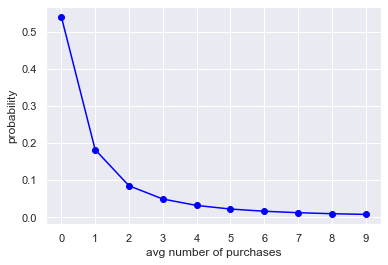

In [73]:

# helper function: probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p
    
    
    
  # call helper function: probability of n repeat purchases within t days
t = 90                  # forecast period, days
purch = range(0,10,1)   # number of repeat purchases 
probs = [prob_purch(t,n) for n in purch]

dict_probs = dict(zip(purch, probs))
#_ = [print(k,":",f'{v:.2f}') for k,v in dict_probs.items()]

plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

Optimization terminated successfully.
         Current function value: -15.268572
         Iterations: 18
         Function evaluations: 20
         Gradient evaluations: 20


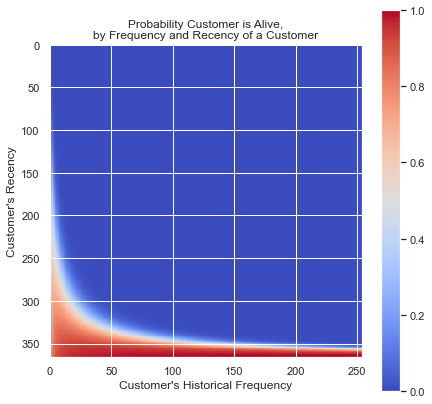

In [74]:
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft[df_rft["frequency"]>0], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary
# probability that a customer has not churned (= is alive), based on 
# customer's specific recency r and frequency f
fig = plt.figure(figsize=(7, 7)) 
plot_probability_alive_matrix(
            model = bgf,  
            max_frequency = max_freq,  
            max_recency = max_rec);
           

## 計算整體付費用戶存活率，平均66%

In [113]:

# probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

,frequency,recency,T,monetary_value,prob_alive
count,"83,371.00","83,371.00","83,371.00","83,371.00","83,371.00"
mean,3.42,49.73,227.69,10.56,0.66
std,9.66,88.23,107.35,24.83,0.41
min,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,138.00,0.00,0.16
50%,1.00,1.00,252.00,2.99,0.99
75%,3.00,58.00,324.00,9.99,1.00
max,253.00,365.00,365.00,"1,827.46",1.00


## 計算整體一次付費用戶存活率

In [124]:
df_rft_1 = df_rft[df_rft["monetary_value"] == 0] 
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft[df_rft["monetary_value"] == 0]["frequency"], 
        recency = df_rft[df_rft["monetary_value"] == 0]["recency"], 
        T = df_rft[df_rft["monetary_value"] == 0]["T"])

df_rft_1["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft_1.describe()
df_rft_1

,frequency,recency,T,monetary_value,prob_alive
count,"41,508.00","41,508.00","41,508.00","41,508.00","41,508.00"
mean,0.00,0.00,206.09,0.00,1.00
std,0.00,0.00,108.97,0.00,0.00
min,0.00,0.00,0.00,0.00,1.00
25%,0.00,0.00,111.00,0.00,1.00
50%,0.00,0.00,222.00,0.00,1.00
75%,0.00,0.00,304.00,0.00,1.00
max,0.00,0.00,365.00,0.00,1.00


,frequency,recency,T,monetary_value,prob_alive
user_id,,,,,
584c4c27d8c483735c2feaf5,0.00,0.00,227.00,0.00,1.00
584d0927d8c483735c3053cb,0.00,0.00,112.00,0.00,1.00
584d24a1d8c483735c30669b,0.00,0.00,193.00,0.00,1.00
584d3eafd8c483735c307ab1,0.00,0.00,194.00,0.00,1.00
584d4f15d8c483735c3088bd,0.00,0.00,187.00,0.00,1.00
...,...,...,...,...,...
61a7cc59d2e57a054781e9e2,0.00,0.00,0.00,0.00,1.00
61a7d124dca11a0554566d3b,0.00,0.00,0.00,0.00,1.00
61a7ece8d2e57a0547f51e94,0.00,0.00,0.00,0.00,1.00


In [173]:
df_t[df_t["user_id"] == '58af42e12cdf04e224cff3c9'].sort_values(by = 'event_date')

,user_id,event_name,product_id,event_date,rev,country,operating_system
263038,58af42e12cdf04e224cff3c9,in_app_purchase,gold3,2021-05-31,19.99,United States,iOS
227484,58af42e12cdf04e224cff3c9,in_app_purchase,gold3,2021-06-04,19.99,United States,iOS
122994,58af42e12cdf04e224cff3c9,in_app_purchase,gold1,2021-06-08,2.99,United States,iOS
232648,58af42e12cdf04e224cff3c9,in_app_purchase,gold3,2021-06-28,19.99,United States,iOS
435023,58af42e12cdf04e224cff3c9,in_app_purchase,welcome,2021-06-28,4.99,United States,iOS
274800,58af42e12cdf04e224cff3c9,in_app_purchase,gold4,2021-07-04,49.99,United States,iOS
260189,58af42e12cdf04e224cff3c9,in_app_purchase,gold3,2021-07-22,19.99,United States,iOS
210248,58af42e12cdf04e224cff3c9,in_app_purchase,gold3,2021-10-22,19.99,United States,iOS
212119,58af42e12cdf04e224cff3c9,in_app_purchase,gold3,2021-10-27,19.99,United States,iOS
212860,58af42e12cdf04e224cff3c9,in_app_purchase,gold3,2021-11-26,19.99,United States,iOS


### 評估單一客戶

,rev
count,6.000
mean,19.990
std,0.000
min,19.990
25%,19.990
50%,19.990
75%,19.990
max,19.990


customer 5855d279d8c483735c3344a7 : probability of being alive over time


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

customer 5855d279d8c483735c3344a7 's probability of being alive, development over time


count   121.000
mean      0.463
std       0.321
min       0.027
25%       0.118
50%       0.530
75%       0.757
max       1.000
dtype: float64

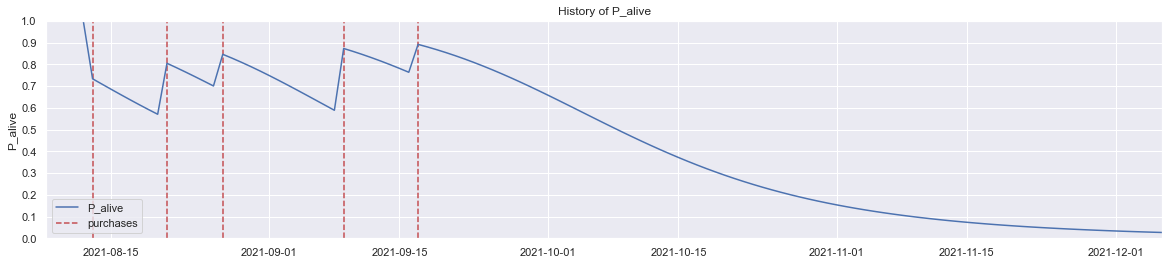

In [181]:
# select a customer

custID = "5855d279d8c483735c3344a7"
span_days = 120
df1C = df_t[df_t["user_id"] == custID]
df1C.describe()



# history of the selected customer: probability over time of being alive
fig = plt.figure(figsize=(20,4))
print("customer",custID,": probability of being alive over time")
plot_history_alive(
                    model = bgf, 
                    t = span_days, 
                    transactions = df1C, 
                    datetime_col = "event_date");
                    
                    
               
 # selected customer's probability of being alive - development over time
path_alive = calculate_alive_path(
            model = bgf, 
            t = span_days, 
            transactions = df1C, 
            datetime_col = "event_date");
print("customer",custID,"'s probability of being alive, development over time")
path_alive.explode().astype(np.float64).describe()

In [115]:

# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,prob_alive
count,"41,863.00","41,863.00","41,863.00","41,863.00","41,863.00"
mean,6.81,99.04,249.11,21.04,0.31
std,12.76,103.05,101.28,31.75,0.33
min,1.00,1.00,1.00,0.99,0.00
25%,1.00,16.00,176.00,4.74,0.02
50%,3.00,57.00,278.00,9.99,0.17
75%,7.00,157.00,339.00,19.99,0.61
max,253.00,365.00,365.00,"1,827.46",1.00


## 發現忠實用戶存活率比起整體付費下降，比較分析原因
welcome budle可能嚴重影響存活，但是這些用戶只買一次

### 比較購買產品差異welcome budle可能嚴重影響存活

In [99]:
df_t[df_t.user_id.isin(df_rft[df_rft["monetary_value"] == 0].index)].product_id.value_counts()

welcome        16484
gold1          12118
gold2           7323
gold3           5017
sp1             1816
gold5           1579
gold4            727
sp2              557
sapphirevip      280
sp3              121
sp4               74
sp5                6
Name: product_id, dtype: int64

In [100]:
df_t[df_t.user_id.isin(df_rft[df_rft["monetary_value"] > 0].index)].product_id.value_counts()

gold1          142510
gold2           87968
gold3           77618
gold5           38606
welcome         17582
gold4           14038
sp1             13486
sp2              7641
sp3              2516
sapphirevip      2338
sp4              2187
sp5               768
Name: product_id, dtype: int64

## 忠實用戶只有平均31%存活率查看詳細統計，得短時間買大量、但是長時間沒有購買

In [116]:
df_rftv[df_rftv['prob_alive']<=0.31]

,frequency,recency,T,monetary_value,prob_alive
user_id,,,,,
584d4d81d8c483735c308788,1.00,5.00,197.00,23.97,0.07
58535381d8c483735c32f6ef,2.00,85.00,287.00,14.99,0.26
5855d279d8c483735c3344a7,5.00,40.00,115.00,19.99,0.05
585650c0d8c483735c334a70,3.00,120.00,365.00,95.37,0.15
5863c4fad8c483735c33f67b,2.00,7.00,203.00,23.90,0.01
...,...,...,...,...,...
618c686ec275ee054e1c63a8,2.00,3.00,17.00,50.47,0.28
618c7db7108609a4f279eb57,3.00,5.00,20.00,19.96,0.19
618ca1df108609a4f2235821,2.00,4.00,20.00,6.49,0.28


## 忠實用戶高存活率（>70%）的表現，消費週期離觀察時間點越近，呈現較高存活率

In [175]:
df_rftv[df_rftv['prob_alive']>=0.70]

,CLV,frequency,recency,T,monetary_value,prob_alive
user_id,,,,,,
586dba4dd8c483735c347335,3.49,2.00,119.00,123.00,2.99,0.81
58723fafd8c483735c34a1be,163.36,8.00,355.00,362.00,96.18,0.91
587af093d8c483735c34fa32,273.03,13.00,332.00,353.00,99.99,0.90
589843e82cdf04e224cef109,76.82,85.00,354.00,359.00,4.10,0.97
58af42e12cdf04e224cff3c9,69.17,8.00,179.00,184.00,22.24,0.91
...,...,...,...,...,...,...
61a4a63284878a05601a9b4d,44.05,2.00,2.00,2.00,4.30,0.82
61a50465c275ee054eccd7e7,68.19,1.00,1.00,1.00,10.79,0.77
61a5c12884878a05606fe49a,141.88,1.00,1.00,1.00,22.97,0.77


In [81]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.081


In [82]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

<lifetimes.GammaGammaFitter: fitted with 41863 subjects, p: 21.70, q: 1.37, v: 0.48>

,coef,se(coef),lower 95% bound,upper 95% bound
p,21.705,1.829,18.120,25.289
q,1.371,0.009,1.354,1.389
v,0.485,0.043,0.401,0.568


In [83]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.03


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
user_id,,,,,,,,,,,,
584c82c7d8c483735c301849,1.000,212.000,300.000,4.990,0.027,0.079,0.156,0.230,0.688,5.382,4.990,0.392
584d4d81d8c483735c308788,1.000,5.000,197.000,23.975,0.004,0.013,0.025,0.036,0.073,24.048,23.975,0.073
584e5261d8c483735c311785,4.000,131.000,235.000,18.228,0.069,0.203,0.393,0.573,0.398,18.271,18.228,0.043
58522ce9d8c483735c32c8f7,1.000,104.000,219.000,3.598,0.031,0.091,0.178,0.261,0.583,4.014,3.598,0.416
58535381d8c483735c32f6ef,2.000,85.000,287.000,14.990,0.019,0.057,0.111,0.162,0.256,15.103,14.990,0.113


In [84]:
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
count,"41,863.000","41,863.000","41,863.000","41,863.000","41,863.000","41,863.000","41,863.000","41,863.000","41,863.000","41,863.000","41,863.000","41,863.000"
mean,6.806,99.043,249.110,21.035,0.147,0.420,0.790,1.129,0.314,21.118,21.035,0.082
std,12.765,103.045,101.278,31.748,0.423,1.197,2.248,3.206,0.329,31.539,31.748,0.291
min,1.000,1.000,1.000,0.990,0.000,0.000,0.000,0.000,0.000,1.450,0.990,-9.447
25%,1.000,16.000,176.000,4.738,0.002,0.005,0.010,0.015,0.023,4.827,4.738,0.016
50%,3.000,57.000,278.000,9.990,0.014,0.041,0.080,0.116,0.166,10.298,9.990,0.082
75%,7.000,157.000,339.000,19.990,0.091,0.264,0.505,0.731,0.610,20.130,19.990,0.212
max,253.000,365.000,365.000,"1,827.462",8.285,24.066,46.210,66.897,0.997,"1,825.653","1,827.462",0.460


# 3.客戶終身價值
根據不同時間單位 LIFE   
年利率計算 DISCOUNT_a

## 觀查整體未來的CLV
未來n個月付費玩家貢獻多少美金   
平均新近度
平均消費次數
平均生命週期時間
平均存活率

# 

In [148]:
# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 3                     # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"41,863.00",32.27,160.17,0.00,0.13,1.18,9.83,"9,298.83"
frequency,"41,863.00",6.81,12.76,1.00,1.00,3.00,7.00,253.00
recency,"41,863.00",99.04,103.05,1.00,16.00,57.00,157.00,365.00
T,"41,863.00",249.11,101.28,1.00,176.00,278.00,339.00,365.00
monetary_value,"41,863.00",21.04,31.75,0.99,4.74,9.99,19.99,"1,827.46"
prob_alive,"41,863.00",0.31,0.33,0.00,0.02,0.17,0.61,1.00


## 觀察平均每次消費實際金額和預測金額

In [149]:
df_rftv.sort_values(by='CLV',ascending = False)

,CLV,frequency,recency,T,monetary_value,prob_alive
user_id,,,,,,
60170e5c0a0322055cd79e6b,"9,298.83",73.00,128.00,129.00,235.70,0.98
5cca85b6235bac98e4655e21,"9,230.55",170.00,314.00,316.00,216.80,0.99
5e7be683fb9e6fe8d93bde6f,"7,824.97",154.00,288.00,288.00,185.13,1.00
613cf05a24c59e81a02d3db8,"5,544.49",35.00,81.00,81.00,202.84,0.98
5f05ecee3d5be8696faa5518,"4,386.25",86.00,362.00,365.00,232.77,0.98
...,...,...,...,...,...,...
5ec315b4ef576cb001549bc0,0.00,52.00,65.00,363.00,7.43,0.00
5fca0b7e94061aa942d70b99,0.00,80.00,109.00,362.00,91.10,0.00
5eb4c411e8164a3aacdebdb0,0.00,154.00,195.00,364.00,23.52,0.00


## 比較實際金額與終身價值（注意時間單位）

In [150]:
pd.concat([df_rftv,df_t[df_t['user_id'].isin(df_rftv.index)].groupby('user_id').rev.sum()],axis=1).sort_values(by='CLV',ascending = False)

,CLV,frequency,recency,T,monetary_value,prob_alive,rev
user_id,,,,,,,
60170e5c0a0322055cd79e6b,"9,298.83",73.00,128.00,129.00,235.70,0.98,"17,209.14"
5cca85b6235bac98e4655e21,"9,230.55",170.00,314.00,316.00,216.80,0.99,"36,956.24"
5e7be683fb9e6fe8d93bde6f,"7,824.97",154.00,288.00,288.00,185.13,1.00,"28,560.00"
613cf05a24c59e81a02d3db8,"5,544.49",35.00,81.00,81.00,202.84,0.98,"7,199.28"
5f05ecee3d5be8696faa5518,"4,386.25",86.00,362.00,365.00,232.77,0.98,"20,217.97"
...,...,...,...,...,...,...,...
5ec315b4ef576cb001549bc0,0.00,52.00,65.00,363.00,7.43,0.00,389.44
5fca0b7e94061aa942d70b99,0.00,80.00,109.00,362.00,91.10,0.00,"7,388.00"
5eb4c411e8164a3aacdebdb0,0.00,154.00,195.00,364.00,23.52,0.00,"3,657.78"


## 分群分析比較
分析維度可參考國家、地區、實際上消費額   
一次購買   
後80% CLV   
前20% CLV

In [151]:
once_paid = df_rft[df_rft['frequency']<1]
pct80 = df_rftv[df_rftv['CLV'] < np.quantile(df_rftv['CLV'],0.8)]
pct20 = df_rftv[df_rftv['CLV'] >= np.quantile(df_rftv['CLV'],0.8)]

In [152]:
df_t

,user_id,event_name,product_id,event_date,rev,country,operating_system
0,60ee9ca4770d2399fec7c1c3,in_app_purchase,sapphirevip,2021-11-27,11.07,Indonesia,iOS
1,61487b9453ac7205493a787d,in_app_purchase,sapphirevip,2021-11-28,11.32,Malaysia,Android
2,5f0fc326b69a34096a310203,in_app_purchase,sp3,2021-11-28,13.99,United States,iOS
3,5ec1549fe8164a3aacec1d22,in_app_purchase,sp5,2021-11-28,49.99,United States,iOS
4,6192807f817bd9056afd93c1,in_app_purchase,sapphirevip,2021-11-27,9.99,United States,iOS
...,...,...,...,...,...,...,...
453407,606f7cd7dca11a05542a24c7,in_app_purchase,welcome,2021-07-03,5.65,Canada,Android
453408,5fa05b0194061aa9428a0732,in_app_purchase,welcome,2020-12-29,6.71,Netherlands,Android
453409,607be87ddca11a0554e2f24d,in_app_purchase,welcome,2021-04-18,5.13,Hong Kong,Android
453410,5fcecec194061aa942495945,in_app_purchase,welcome,2020-12-25,4.99,United States,Android


In [153]:
df_once = df_t[df_t['user_id'].isin(once_paid.index)]
df_80 = df_t[df_t['user_id'].isin(pct80.index)]
df_20 = df_t[df_t['user_id'].isin(pct20.index)]
df_rtv_c = pd.concat([
    pd.Series(df_once.groupby(['country','operating_system']).user_id.nunique(),name = 'leaveCustomer'),
    pd.Series(df_80.groupby(['country','operating_system']).user_id.nunique(),name = 'pct80Customer'),
    pd.Series(df_20.groupby(['country','operating_system']).user_id.nunique(),name = 'top20Customer')],axis =1)

In [154]:
CLV_c = pd.concat([df_rftv, df_t[df_t.user_id.isin(df_rftv.index)].groupby('user_id')['country','operating_system'].first()],axis =1 ).groupby(['country','operating_system']).CLV.sum()
df_rtv_c = pd.concat([df_rtv_c,CLV_c],axis=1)
df_rtv_c = df_rtv_c.reset_index('operating_system')

In [155]:
pd.options.display.float_format = '{:,.2f}'.format
df_rtv_c['unique'] = df_rtv_c[df_rtv_c.columns[1]]+df_rtv_c[df_rtv_c.columns[2]]+df_rtv_c[df_rtv_c.columns[3]]
df_rtv_c['leaveCustomer'] = df_rtv_c['leaveCustomer'] / df_rtv_c['unique']
df_rtv_c['pct80Customer'] = df_rtv_c['pct80Customer'] / df_rtv_c['unique']
df_rtv_c['top20Customer'] = df_rtv_c['top20Customer'] / df_rtv_c['unique']
df_rtv_c['ARPC(Customer)'] = df_rtv_c['CLV'] / df_rtv_c['unique'] 

### 實際各國家預期產值、平均預期消費

In [163]:
df_rtv_c[df_rtv_c['operating_system']=='iOS'].sort_values(by='CLV',ascending=False).head(10)


,operating_system,leaveCustomer,pct80Customer,top20Customer,CLV,unique,ARPC(Customer)
country,,,,,,,
United States,iOS,0.48,0.40,0.12,"639,922.31","33,516.00",19.09
Mongolia,iOS,0.34,0.48,0.18,"99,228.11","2,262.00",43.87
India,iOS,0.42,0.44,0.13,"41,740.91","2,322.00",17.98
Japan,iOS,0.54,0.39,0.07,"25,989.38","3,693.00",7.04
Singapore,iOS,0.42,0.35,0.23,"24,708.47","1,184.00",20.87
United Kingdom,iOS,0.51,0.41,0.09,"24,271.86","3,315.00",7.32
Canada,iOS,0.49,0.42,0.09,"23,374.78","2,358.00",9.91
Vietnam,iOS,0.46,0.44,0.09,"21,527.27","2,667.00",8.07
Germany,iOS,0.50,0.35,0.15,"14,484.21",942.00,15.38


In [161]:
df_rtv_c[df_rtv_c['operating_system']=='iOS'].sort_values(by='CLV',ascending=False).head(30).corr()


,leaveCustomer,pct80Customer,top20Customer,CLV,unique,ARPC(Customer)
leaveCustomer,1.00,-0.30,-0.78,0.10,0.17,-0.66
pct80Customer,-0.30,1.00,-0.35,-0.02,-0.04,0.01
top20Customer,-0.78,-0.35,1.00,-0.09,-0.15,0.64
CLV,0.10,-0.02,-0.09,1.00,0.99,-0.04
unique,0.17,-0.04,-0.15,0.99,1.00,-0.09
ARPC(Customer),-0.66,0.01,0.64,-0.04,-0.09,1.00


In [162]:
df_rtv_c[df_rtv_c['operating_system']=='Android'].sort_values(by='CLV',ascending=False).head(10)

,operating_system,leaveCustomer,pct80Customer,top20Customer,CLV,unique,ARPC(Customer)
country,,,,,,,
United States,Android,0.49,0.40,0.11,"168,366.67","11,504.00",14.64
India,Android,0.45,0.45,0.10,"28,006.98","1,858.00",15.07
Norway,Android,0.43,0.30,0.27,"27,724.17",320.00,86.64
Canada,Android,0.49,0.42,0.09,"17,384.42","1,164.00",14.94
Israel,Android,0.37,0.45,0.19,"16,019.01",458.00,34.98
United Kingdom,Android,0.54,0.40,0.05,"8,758.37","1,338.00",6.55
Serbia,Android,0.43,0.37,0.20,"7,992.69",154.00,51.90
Germany,Android,0.54,0.38,0.08,"5,280.56",393.00,13.44
Singapore,Android,0.47,0.42,0.11,"4,139.32",366.00,11.31


In [159]:
df_rtv_c[df_rtv_c['operating_system']=='Android'].sort_values(by='CLV',ascending=False).head(30).corr()

,leaveCustomer,pct80Customer,top20Customer,CLV,unique,ARPC(Customer)
leaveCustomer,1.00,-0.58,-0.73,-0.12,-0.04,-0.58
pct80Customer,-0.58,1.00,-0.12,0.08,0.13,-0.12
top20Customer,-0.73,-0.12,1.00,0.07,-0.06,0.80
CLV,-0.12,0.08,0.07,1.00,0.98,0.09
unique,-0.04,0.13,-0.06,0.98,1.00,-0.05
ARPC(Customer),-0.58,-0.12,0.80,0.09,-0.05,1.00


## 前20%用戶每次消費狀況

In [176]:
pct20.describe()

,CLV,frequency,recency,T,monetary_value,prob_alive
count,"8,373.00","8,373.00","8,373.00","8,373.00","8,373.00","8,373.00"
mean,152.57,15.70,197.86,227.66,45.04,0.74
std,331.87,21.63,119.55,122.61,44.61,0.23
min,16.10,1.00,1.00,1.00,2.57,0.02
25%,28.19,4.00,82.00,113.00,12.27,0.63
50%,56.48,9.00,215.00,260.00,22.90,0.82
75%,144.77,19.00,311.00,346.00,83.32,0.92
max,"9,298.83",253.00,365.00,365.00,766.59,1.00


## 後80%用戶每次消費狀況

In [177]:
pct80.describe()

,CLV,frequency,recency,T,monetary_value,prob_alive
count,"33,490.00","33,490.00","33,490.00","33,490.00","33,490.00","33,490.00"
mean,2.20,4.58,74.34,254.47,15.03,0.21
std,3.49,7.88,81.54,94.44,24.13,0.25
min,0.00,1.00,1.00,3.00,0.99,0.00
25%,0.07,1.00,12.00,188.00,4.01,0.01
50%,0.52,2.00,43.00,281.00,8.99,0.08
75%,2.65,5.00,110.00,337.00,16.66,0.33
max,16.10,208.00,365.00,365.00,"1,827.46",0.97


## 前20%用戶消費狀況

In [97]:
pct20.describe()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,prob_alive,exp_avg_rev,avg_rev,error_rev
count,"8,373.00","8,373.00","8,373.00","8,373.00","8,373.00","8,373.00","8,373.00","8,373.00","8,373.00","8,373.00","8,373.00","8,373.00","8,373.00"
mean,152.57,15.70,197.86,227.66,45.04,0.61,1.73,3.26,4.65,0.74,44.93,45.04,-0.11
std,331.87,21.63,119.55,122.61,44.61,0.78,2.21,4.14,5.91,0.23,44.38,44.61,0.35
min,16.10,1.00,1.00,1.00,2.57,0.01,0.03,0.05,0.08,0.02,2.63,2.57,-9.45
25%,28.19,4.00,82.00,113.00,12.27,0.15,0.45,0.86,1.24,0.63,12.30,12.27,-0.09
50%,56.48,9.00,215.00,260.00,22.90,0.34,0.99,1.87,2.69,0.82,22.91,22.90,0.00
75%,144.77,19.00,311.00,346.00,83.32,0.74,2.12,3.97,5.66,0.92,83.01,83.32,0.02
max,"9,298.83",253.00,365.00,365.00,766.59,8.29,24.07,46.21,66.90,1.00,762.40,766.59,0.43
